In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [2]:
steps=20000
lr=1e-3

In [3]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        a = x.float()
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a


Our operator is:

## $$ F(x) = a \cdot sin(b \cdot x + c)$$

And we know the origin form is :

## $$ F(x) = sin(x) $$

## $$ y = a1 \cdot x^3 + a2 \cdot sin(a3 \cdot x) + a4 \cdot exp ( a5 \cdot x) $$

## $$ y = 5 \cdot x^3 + 2 \cdot sin(2 \cdot x) -2 \cdot exp ( 2 \cdot x) $$

In [4]:
def f(x):
    y= torch.sin(x)
    return y


class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class super().__init__()
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        'Initialize our new parameters i.e. 𝜆 (Inverse problem)' 
        self.lambda1 = torch.tensor([lambda1], requires_grad=False).float().to(device)  
        self.lambda2 = torch.tensor([lambda2], requires_grad=False).float().to(device)
        self.lambda3 = torch.tensor([lambda2], requires_grad=False).float().to(device)
        
        'Register lambda to optimize'
        self.lambda1 = nn.Parameter(self.lambda1.clamp(0.8,1.2))
        self.lambda2 = nn.Parameter(self.lambda2.clamp(0.8,1.2))
        self.lambda3 = nn.Parameter(self.lambda3.clamp(-0.2,0.2))
        
        'Call our DNN'
        self.dnn = DNN(layers).to(device)
        'Register our new parameter'
        self.dnn.register_parameter('lambda1', self.lambda1)  
        self.dnn.register_parameter('lambda2', self.lambda2)      
        self.dnn.register_parameter('lambda3', self.lambda3)

        

    def lossformula(self,x_real):      # The Most Important issue
        lambda1 = self.lambda1
        lambda2 = self.lambda2
        lambda3 = self.lambda3
        
        g = x_real.clone()
        
        g.requires_grad=True #Enable differentiation
            
        y = self.dnn(g)
        
        f = (lambda1) * torch.sin((g[:, 0:1])*(lambda2) + (lambda3)) - y 
#         f = (lambda1) * torch.sin(self.dnn(g[:, 0:1])*(lambda2) + lambda3) #- torch.sin((x_real)) 

        loss_f = self.loss_function(f, f_hat)
                                                                                       
        return loss_f
    
    
    def loss(self, x, y):
        loss_mse = self.loss_function(self.dnn(x),y)
        loss_formula = self.lossformula(x)
        loss_val = loss_mse + loss_formula
        return loss_val


    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(
                'Relative Error(Test): %.5f , 𝜆_real = [1.0,  1.0, 0.0], 𝜆_PINN = [%.5f,  %.5f, %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    self.lambda1.item(),
                    self.lambda2.item(),
                    self.lambda3.item()
                )
            )
            

        return loss
    
    'test neural network'
    def test(self):
                
        y_pred = self.dnn(x_real)
        
        error_vec = torch.linalg.norm((y_real - y_pred),2)/torch.linalg.norm(y_real,2)        # Relative L2 Norm of the error (Vector)
        
        y_pred = y_pred.cpu().detach().numpy()
        
        y_pred = np.reshape(y_pred,(x.shape[0]),order='F')
                
        return error_vec, y_pred

In [5]:
# get the analytical solution over the full domain
x = torch.linspace(0,4*np.pi,500).view(-1,1) #prepare to NN
noise =  2 * np.random.normal(size=500)
y = f(x) + torch.randn(500, 1)/10
x_real = torch.linspace(0, 4*np.pi, 500).view(-1, 1)
y_real = np.sin(x_real)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


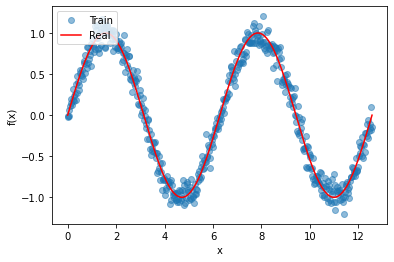

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),'o',label='Train', alpha = 0.5)
ax1.plot(x_real.detach().numpy(), y_real.detach().numpy(), 'r', label = 'Real')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [7]:
indices=np.arange(500)

In [8]:
x_train = x[indices]
y_train = y[indices]

In [9]:
'Convert our arrays to tensors and send them to our GPU'
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_real = x_real.float().to(device)
y_real = y_real.float().to(device)
f_hat = torch.zeros(x_train.shape[0],1).to(device)

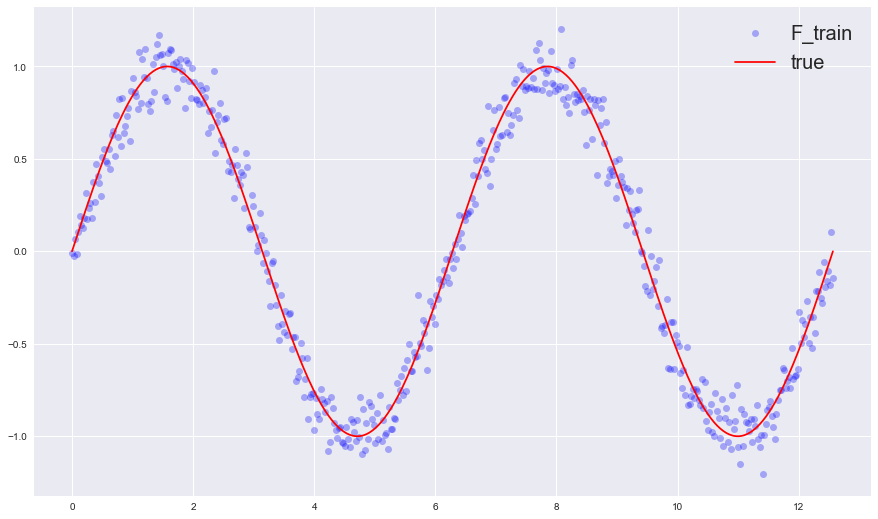

In [10]:
plt.figure(figsize = (15, 9))
plt.style.use('seaborn')
plt.plot(x_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'bo', alpha = 0.3, label = 'F_train')
plt.plot(x_real.detach().cpu().numpy(), y_real.detach().cpu().numpy(),'r-', label = 'true')
plt.legend(fontsize = 20)

In [11]:
layers = np.array([1, 50, 50, 50, 50, 50, 50, 50,1]) #8 hidden layers

In [12]:
steps=10000
lr= 0.01

In [13]:
lambda1 = 0.6
lambda2 = 1.7
lambda3 = 0
print("Te real 𝜆 = [", 1.0,1.0,0.0,"]. Our initial guess will be 𝜆 _PINN= [",lambda1,lambda2,lambda3,"]")

Te real 𝜆 = [ 1.0 1.0 0.0 ]. Our initial guess will be 𝜆 _PINN= [ 0.6 1.7 0 ]


In [14]:
PINN = FCN(layers)
       
PINN

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              tolerance_grad = 1e-8, 
                              tolerance_change = 1e-9, 
                              history_size = 30)

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=1, bias=True)
  )
  (dnn): DNN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Linear(in_features=50, out_features=50, bias=True)

In [15]:
def test_func(x, a, b, c):
    return a * np.sin(b * x + c)

In [16]:
a, b, c = PINN.lambda1.detach().cpu().numpy(), PINN.lambda2.detach().cpu().numpy(), PINN.lambda3.detach().cpu().numpy()
a, b, c

(array([0.99396056], dtype=float32),
 array([1.0005573], dtype=float32),
 array([-0.01200568], dtype=float32))

In [17]:
from scipy import optimize

def test_func(x, a, b, c):
    return a * np.sin(b * x + c)

x_fit = x.detach().cpu().numpy().reshape(500, )
y_fit = y.detach().cpu().numpy().reshape(500, )

params, params_covariance = optimize.curve_fit(test_func, x_fit, y_fit, p0=[1.5, 1.7, 2])

print(params)

[-0.17026383  1.70162026  1.78364943]


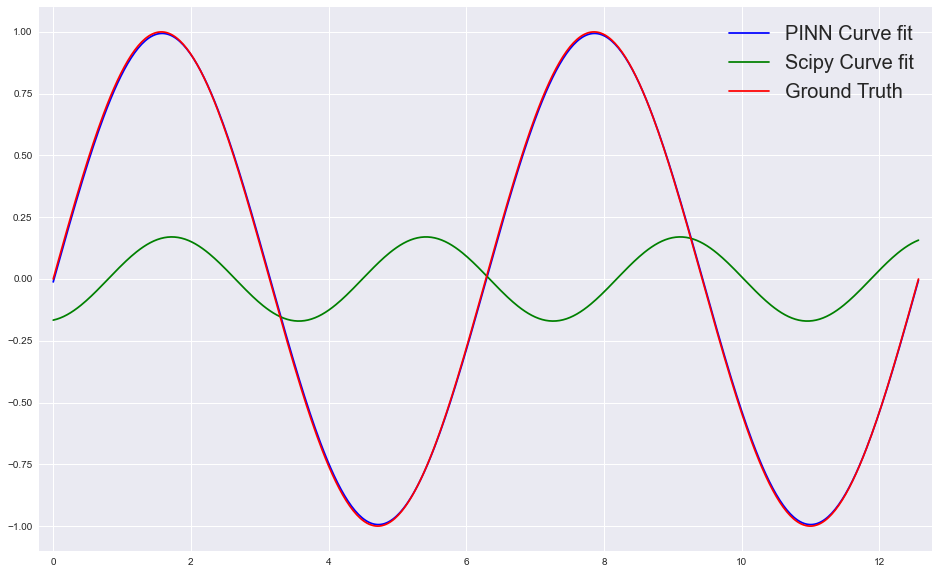

In [22]:
plt.figure(figsize = (16, 10))
plt.plot(x.detach().cpu().numpy(), test_func(x.detach().cpu().numpy(), a, b, c), 'b', label = 'PINN Curve fit')
plt.plot(x.detach().cpu().numpy(), test_func(x.detach().cpu().numpy(), params[0], params[1], params[2]), 'g-', label = 'Scipy Curve fit')
plt.plot(x.detach().cpu().numpy(), f(x), 'r-', label = 'Ground Truth ')
plt.xlim([-0.2, 4*np.pi + 0.2])
plt.grid('True')
plt.legend(fontsize = 20)
plt.show()

In [19]:
mse_pinn = 0
mse_scipy = 0
for i in range(500):
    mse_pinn += (f(x).detach().cpu().numpy()[i] - test_func(x.detach().cpu().numpy(), PINN.lambda1.detach().cpu().numpy(), PINN.lambda2.detach().cpu().numpy(), PINN.lambda3.detach().cpu().numpy())[i])**2
    mse_scipy += (f(x).detach().cpu().numpy()[i] - test_func(x.detach().cpu().numpy(), params[0], params[1], params[2])[i])**2
    

print(mse_pinn)
print(mse_scipy)

[0.02902044]
[243.01099]


In [20]:
diff_pinn = f(x) - test_func(x.detach().cpu().numpy(), a, b, c)
diff_scipy = f(x) - test_func(x.detach().cpu().numpy(), params[0], params[1], params[2])

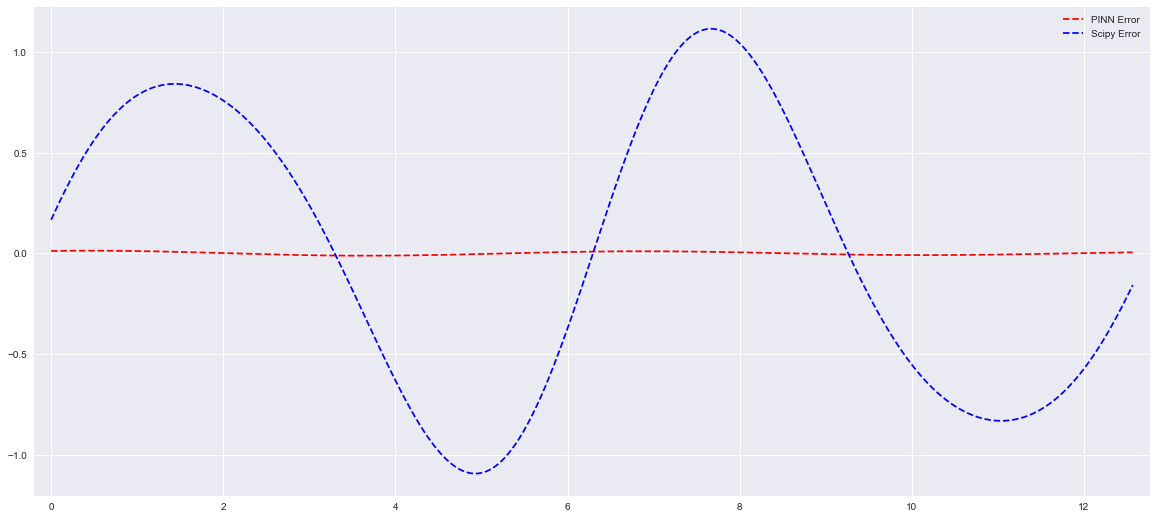

In [21]:
plt.figure(figsize = (20, 9))
plt.plot(x, diff_pinn, 'r--', label = 'PINN Error')
plt.plot(x, diff_scipy, 'b--', label = 'Scipy Error')
plt.xlim([-0.2, 4*np.pi+0.2])
plt.grid(True)
plt.legend()
plt.show()